## Do Certain Players Have Certain Skillsets on PGA Tour?

- I will look at player averages in all categories to try to see if a statistically significant difference exists

In [5]:
import os

os.chdir('../data collection/')

In [6]:
from pymongo import MongoClient
from connect import CONN

# establish connection with database
connection = MongoClient(CONN)

# select database
db = connection['strokes-gained']

In [153]:
# different collection in database
db.list_collection_names()

['tournaments', 'players']

In [154]:
import pandas as pd
import numpy as np

# query data including all players
players = db['players'].find({}, {'_id': 0})

# convert cursor object to dataframe
data: pd.DataFrame = pd.DataFrame(players)
data.head()

,pos,player_name,score,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,tournament_id
0,1,Adam Svensson,-19,3.08,0.28,0.80,0.96,2.04,3.15,1
1,T2,Callum Tarren,-17,1.00,0.33,1.90,0.15,2.38,2.86,1
2,T2,Sahith Theegala,-17,2.19,0.37,-0.39,0.62,0.60,2.65,1
3,T2,Brian Harman,-17,0.86,0.15,1.31,0.13,1.59,2.65,1
4,T5,Joel Dahmen,-15,0.73,-0.10,-0.03,0.79,0.65,2.36,1


### Aggregate Players Data

- Get averages for all stats
- Get number of tournaments each player has

In [155]:
# copy data
df = data.copy()

# get average stats
average_stats = df.copy().groupby('player_name')[['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g']].mean()

# get number of tournaments played
num_tournaments = df.groupby('player_name')['tournament_id'].count()

In [156]:
from classes import KMeans

# cluster distance
cd = []

# looking at how good the clusters are for different values of k
for clusters in range(2, 6):
    kmeans = KMeans(clusters, average_stats, ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g'])
    cluster_centers = kmeans.fit(True)

    print(f'{clusters}: {kmeans.score}')

    cd.append(kmeans.score)

2: 1.550899002466579
3: 1.3991598886051224
4: 1.3124310657111171
5: 1.2560498353154235


### Creating Plot Showing Different Values of K

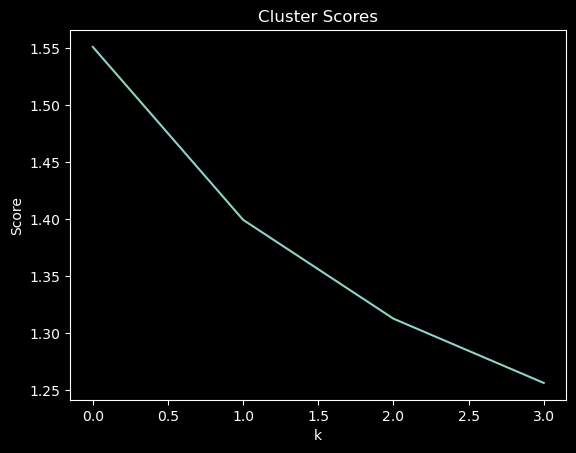

In [157]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")

plt.plot(cd)
plt.title('Cluster Scores')
plt.xlabel('k')
plt.ylabel('Score')
plt.show()

### Start with 5 Clusters for Players

In [158]:
# create kmeans object
averages = KMeans(5, average_stats, ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g'])

# cluster data
clusters = averages.fit(True)
clustered_df = averages.transform()

In [159]:
clustered_df['cluster'].value_counts()

4    429
0    282
1    258
3    131
2    120
Name: cluster, dtype: int64

### Looking at Golf Course Data

In [160]:
# get data from tournaments collection
tournaments = db['tournaments'].find({}, {'_id': 0})
players = db['players'].find(
    {}, 
    {'_id': 0, 'tournament_id': 1, 'sg_putt': 1, 'sg_arg': 1, 'sg_app': 1, 'sg_ott': 1, 'sg_t2g': 1}
)

# create new dataframe
tournaments = pd.DataFrame(tournaments)
players = pd.DataFrame(players)

# join DataFrames
df = players.merge(tournaments, on='tournament_id')
df.head()

,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,tournament_id,name,year,location
0,3.08,0.28,0.80,0.96,2.04,1,RSM Classic,2022,Georgia
1,1.00,0.33,1.90,0.15,2.38,1,RSM Classic,2022,Georgia
2,2.19,0.37,-0.39,0.62,0.60,1,RSM Classic,2022,Georgia
3,0.86,0.15,1.31,0.13,1.59,1,RSM Classic,2022,Georgia
4,0.73,-0.10,-0.03,0.79,0.65,1,RSM Classic,2022,Georgia


In [161]:
def fix_duplicates(df: pd.DataFrame, names: list, correct_name: str) -> pd.DataFrame:
    """This is a function helping clean data by removing duplicated names with slight misspellings"""
    x: pd.DataFrame = df.query('name in {}'.format(names)).copy()
    not_x: pd.DataFrame = df.query('name not in {}'.format(names)).copy()

    x['name'] = correct_name
    df = pd.concat([x, not_x], axis=0)

    return df

In [162]:
df = fix_duplicates(df, ['Barbasol', 'Barbasol Championship'], 'Barbasol Championship')
df = fix_duplicates(df, ['Fedex St. Jude Championship', 'FedEx St. Jude Championship'], 'FedEx St. Jude Championship')
df = fix_duplicates(df, ['Rbc Canadian Open', 'RBC Canadian Open'], 'RBC Canadian Open')
df = fix_duplicates(df, ['Sony Open In Hawaii', 'Sony Open in Hawaii'], 'Sony Open in Hawaii')
df = fix_duplicates(df, ['RSM Classic', 'The RSM Classic'], 'RSM Classic')
df = fix_duplicates(df, ['The PLAYERS Championship', 'The Players'], 'The PLAYERS Championship')
df = fix_duplicates(df, ['US Open', 'U.S. Open'], 'US Open')
df = fix_duplicates(df, ['Valspar', 'Valspar Championship'], 'Valspar Championship')
df = fix_duplicates(df, ['Wells Fargo', 'Wells Fargo Championship', 'Wells Fargo Chapionship'], 'Wells Fargo Championship')
df = fix_duplicates(df, ['the Memorial Tournament', 'The Memorial Tournament'], 'the Memorial Tournament')

In [163]:
# getting a bunch of summary stats by tournament
super_agg: pd.DataFrame = df.groupby('name').describe()
super_agg.head()

sg_putt                                      \
                             count      mean       std    min      25%   
name                                                                     
3M Open                      617.0 -0.136047  1.074774 -3.470 -0.84500   
AT&T Byron Nelson            778.0 -0.149149  1.113489 -4.407 -0.77250   
AT&T Pebble Beach Pro-Am     928.0 -0.154316  1.512550 -6.347 -1.09000   
Arnold Palmer Invitational   725.0 -0.139204  1.084848 -3.724 -0.77000   
BMW Championship             412.0  0.000432  0.873182 -3.070 -0.51825   

                                                   sg_arg            ...  \
                               50%      75%    max  count      mean  ...   
name                                                                 ...   
3M Open                    -0.0220  0.59000  2.260  617.0 -0.048100  ...   
AT&T Byron Nelson          -0.0500  0.59225  3.511  778.0 -0.069032  ...   
AT&T Pebble Beach Pro-Am   -0.0395  0.83500  4.168  928.0 -0.057143  ...   
Arnold Palmer Invitational -0.0510  0.60000  2.506  725.0 -0.082166  ...   
BMW Championship            0.0010  0.57475  3.644  412.0  0.000667  ...   

                            sg_t2g        tournament_id              \
                               75%    max         count        mean   
name                                                                  
3M Open                     0.9650  4.160         617.0  119.437601   
AT&T Byron Nelson           0.7975  3.577         778.0   93.071979   
AT&T Pebble Beach Pro-Am    1.1755  5.569         930.0   55.681720   
Arnold Palmer Invitational  0.8940  3.369         725.0   73.008276   
BMW Championship            0.7140  3.397         412.0  144.371359   

                                                                         
                                  std   min    25%    50%    75%    max  
name                                                                     
3M Open                     51.753221  29.0  148.0  149.0  150.0  150.0  
AT&T Byron Nelson           36.984048  19.0  110.0  111.0  112.0  113.0  
AT&T Pebble Beach Pro-Am    21.126809   8.0   63.0   65.0   66.0   67.0  
Arnold Palmer Invitational  27.084581  12.0   83.0   84.0   86.0   87.0  
BMW Championship            49.156391  33.0  164.0  166.0  167.0  168.0  

[5 rows x 48 columns]

In [164]:
# extracting data and storing in a series object
putting: pd.DataFrame = super_agg['sg_putt']
around_green: pd.DataFrame = super_agg['sg_arg']
approach: pd.DataFrame = super_agg['sg_app']
off_the_tee: pd.DataFrame = super_agg['sg_ott']
tee_2_green: pd.DataFrame = super_agg['sg_t2g']

### Putting Clusters by Torunament

In [165]:
putting.head()

,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
3M Open,617.0,-0.136047,1.074774,-3.470,-0.84500,-0.0220,0.59000,2.260
AT&T Byron Nelson,778.0,-0.149149,1.113489,-4.407,-0.77250,-0.0500,0.59225,3.511
AT&T Pebble Beach Pro-Am,928.0,-0.154316,1.512550,-6.347,-1.09000,-0.0395,0.83500,4.168
Arnold Palmer Invitational,725.0,-0.139204,1.084848,-3.724,-0.77000,-0.0510,0.60000,2.506
BMW Championship,412.0,0.000432,0.873182,-3.070,-0.51825,0.0010,0.57475,3.644


In [166]:
from classes import KMeans

# side note: I have chosen 5 clusters for this it seemed to give the best results
# and it makes sense to group the tournaments into 5 groups so the groups are fairly small
# and even

# cluster putting stats into 5 groups
kmeans = KMeans(5, putting.copy(), ['mean', 'std', 'min', '25%', '50%', '75%', 'max'])

# create clusters
clusters = kmeans.fit(True)
putting_clustered = kmeans.transform()

# take a look at new data
print(putting_clustered.head())

                            count      mean       std    min      25%     50%  \
name                                                                            
3M Open                     617.0 -0.136047  1.074774 -3.470 -0.84500 -0.0220   
AT&T Byron Nelson           778.0 -0.149149  1.113489 -4.407 -0.77250 -0.0500   
AT&T Pebble Beach Pro-Am    928.0 -0.154316  1.512550 -6.347 -1.09000 -0.0395   
Arnold Palmer Invitational  725.0 -0.139204  1.084848 -3.724 -0.77000 -0.0510   
BMW Championship            412.0  0.000432  0.873182 -3.070 -0.51825  0.0010   

                                75%    max  cluster  
name                                                 
3M Open                     0.59000  2.260        2  
AT&T Byron Nelson           0.59225  3.511        0  
AT&T Pebble Beach Pro-Am    0.83500  4.168        3  
Arnold Palmer Invitational  0.60000  2.506        4  
BMW Championship            0.57475  3.644        0  


In [167]:
putting_clustered['cluster'].value_counts()

4    11
0     7
1     7
3     5
2     4
Name: cluster, dtype: int64

In [168]:
def plots(df: pd.DataFrame) -> None:
    df.query('cluster == 0')[['std', 'mean', '25%', '50%', '75%']].plot(kind='bar')
    df.query('cluster == 1')[['std', 'mean', '25%', '50%', '75%']].plot(kind='bar')
    df.query('cluster == 2')[['std', 'mean', '25%', '50%', '75%']].plot(kind='bar')
    df.query('cluster == 3')[['std', 'mean', '25%', '50%', '75%']].plot(kind='bar')
    df.query('cluster == 4')[['std', 'mean', '25%', '50%', '75%']].plot(kind='bar')

    return None

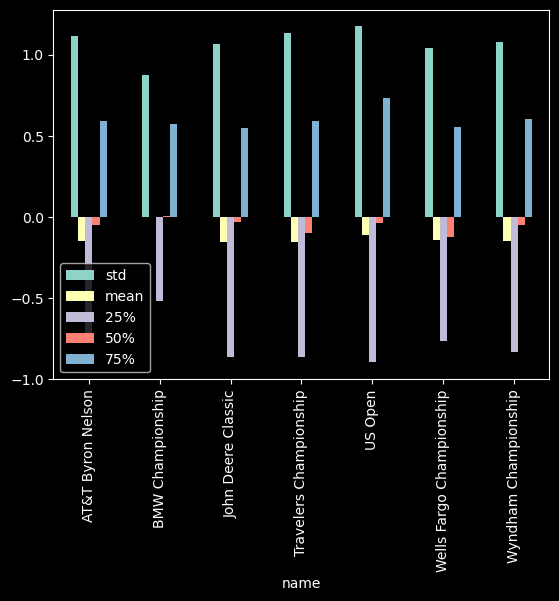

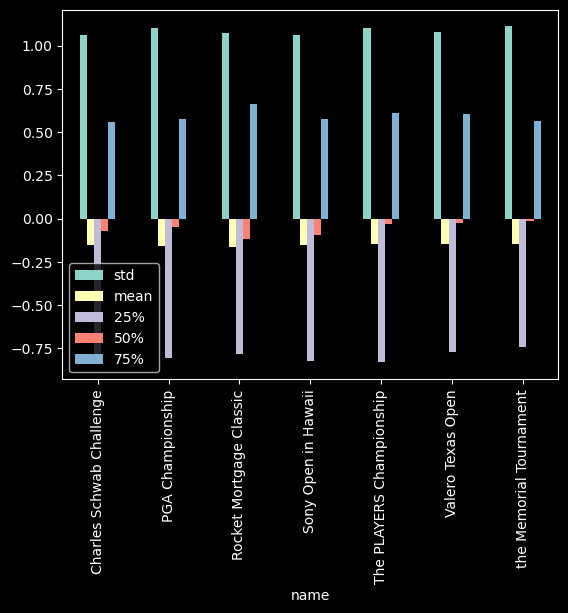

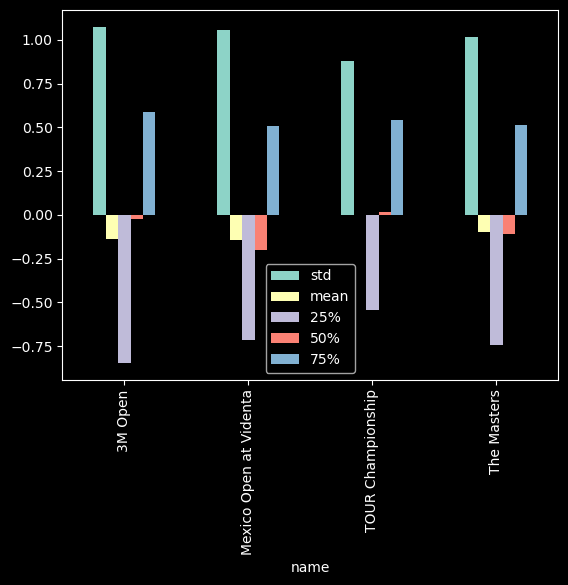

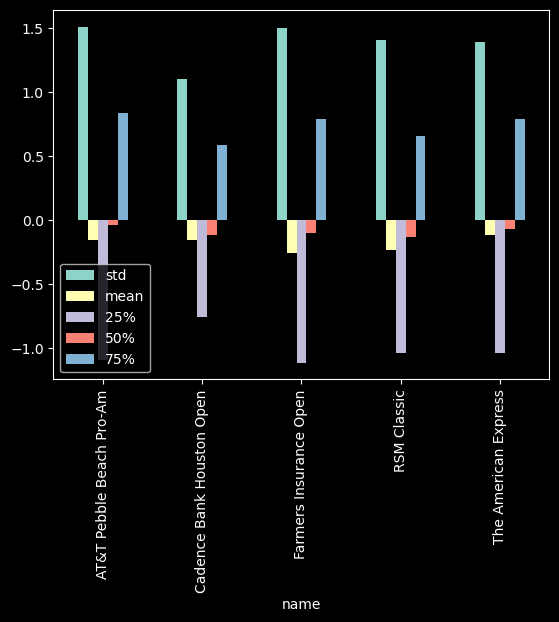

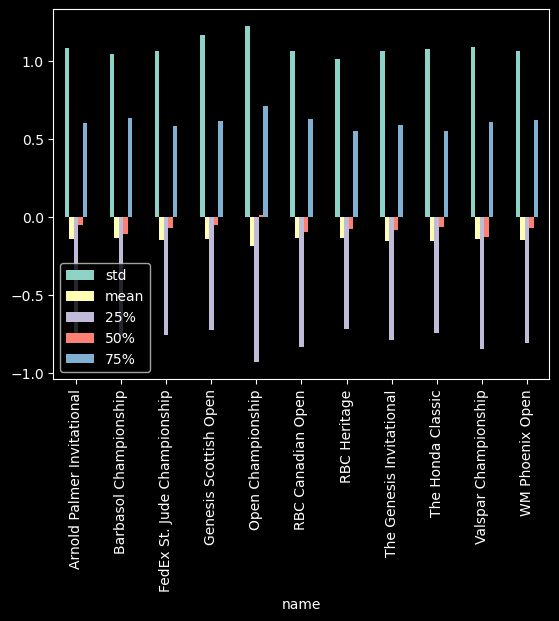

In [169]:
plots(putting_clustered)

### Around the Green by Tournament

In [170]:
# just looking at around green summary statistics
around_green.head()

,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
3M Open,617.0,-0.048100,0.658708,-3.202,-0.41500,-0.010,0.36000,2.030
AT&T Byron Nelson,778.0,-0.069032,0.642561,-2.695,-0.47075,0.004,0.36975,1.633
AT&T Pebble Beach Pro-Am,928.0,-0.057143,1.001671,-4.263,-0.61450,-0.036,0.59000,3.171
Arnold Palmer Invitational,725.0,-0.082166,0.799236,-3.030,-0.56600,-0.011,0.42600,2.491
BMW Championship,412.0,0.000667,0.493584,-1.821,-0.33225,-0.024,0.32175,1.519


In [171]:
# side note: I have chosen 5 clusters for this it seemed to give the best results
# and it makes sense to group the tournaments into 5 groups so the groups are fairly small
# and even

# time to cluster these statistics
kmeans2 = KMeans(5, around_green.copy(), ['mean', 'std', 'min', '25%', '50%', '75%', 'max'])

# now to find clusters and transform dataframe to include clusters
clusters = kmeans2.fit(True)
around_green_clustered = kmeans2.transform()

# display updated dataframe
around_green_clustered.head()

,count,mean,std,min,25%,50%,75%,max,cluster
name,,,,,,,,,
3M Open,617.0,-0.048100,0.658708,-3.202,-0.41500,-0.010,0.36000,2.030,4
AT&T Byron Nelson,778.0,-0.069032,0.642561,-2.695,-0.47075,0.004,0.36975,1.633,4
AT&T Pebble Beach Pro-Am,928.0,-0.057143,1.001671,-4.263,-0.61450,-0.036,0.59000,3.171,3
Arnold Palmer Invitational,725.0,-0.082166,0.799236,-3.030,-0.56600,-0.011,0.42600,2.491,0
BMW Championship,412.0,0.000667,0.493584,-1.821,-0.33225,-0.024,0.32175,1.519,1


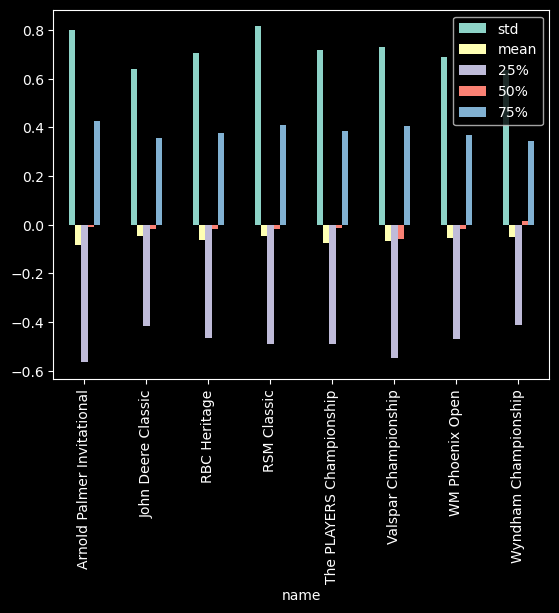

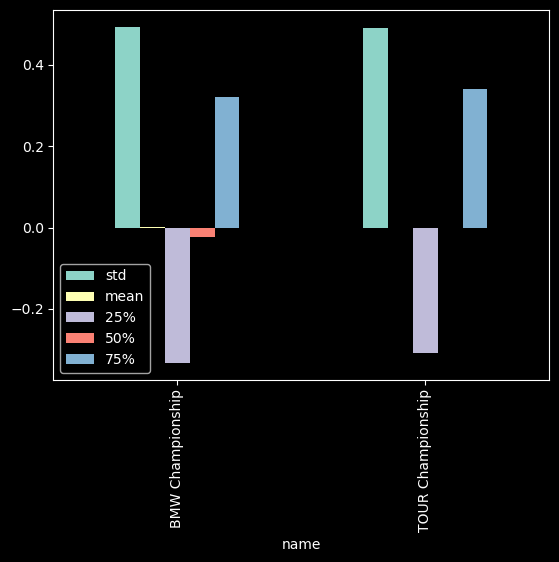

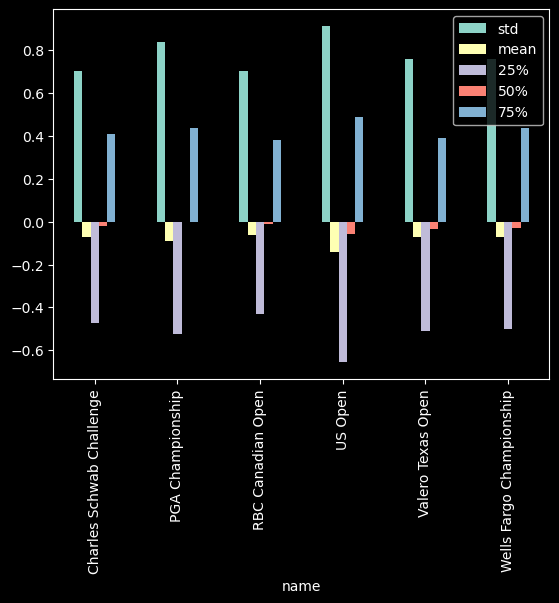

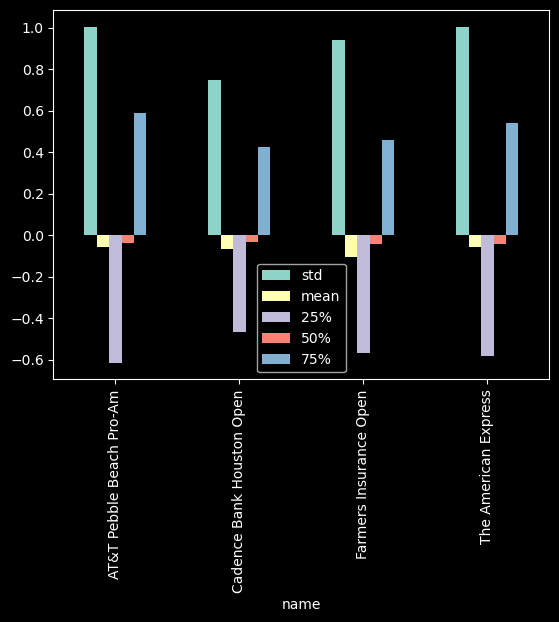

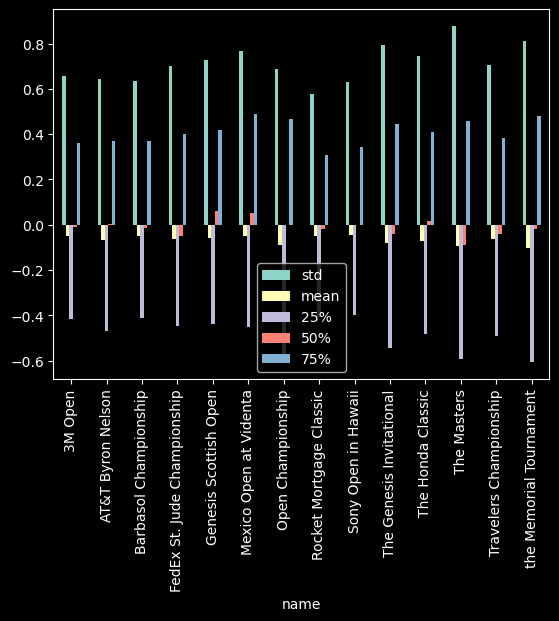

In [172]:
plots(around_green_clustered)

### Approach by Tournament

In [173]:
# side note: I have chosen 5 clusters for this it seemed to give the best results
# and it makes sense to group the tournaments into 5 groups so the groups are fairly small
# and even

# cluster the approach stats
kmeans3 = KMeans(5, approach.copy(), ['mean', 'min', '25%', '50%', '75%', 'max'])

# create clusters
clusters = kmeans3.fit(True)
approach_clustered = kmeans3.transform()

# look at updated data
print(approach_clustered.head(), approach_clustered['cluster'].value_counts(), sep='\n')

                            count      mean       std    min      25%    50%  \
name                                                                           
3M Open                     617.0 -0.196817  1.265776 -6.525 -1.00800 -0.040   
AT&T Byron Nelson           778.0 -0.140212  1.018312 -4.734 -0.76975 -0.077   
AT&T Pebble Beach Pro-Am    928.0 -0.152256  1.535632 -7.012 -1.03500 -0.050   
Arnold Palmer Invitational  725.0 -0.161212  1.124428 -5.296 -0.79100 -0.030   
BMW Championship            412.0 -0.001944  0.764910 -2.841 -0.44450  0.051   

                                75%    max  cluster  
name                                                 
3M Open                     0.67300  2.678        2  
AT&T Byron Nelson           0.53600  2.800        3  
AT&T Pebble Beach Pro-Am    0.86475  3.919        2  
Arnold Palmer Invitational  0.59300  2.639        3  
BMW Championship            0.50650  2.050        0  
3    12
0    12
2     5
4     4
1     1
Name: cluster, dtype:

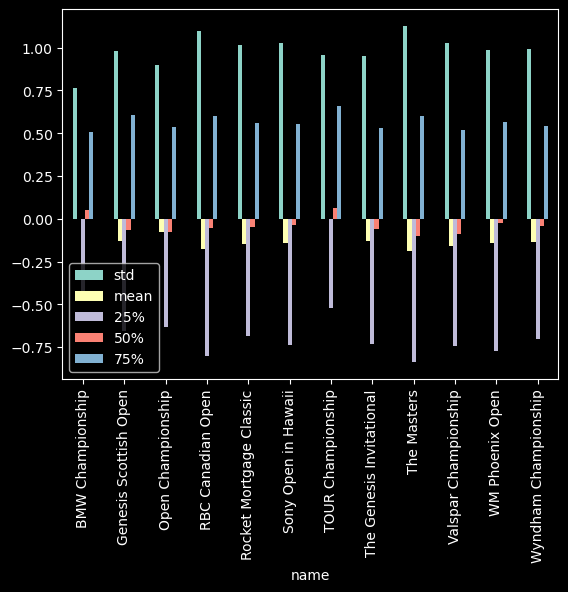

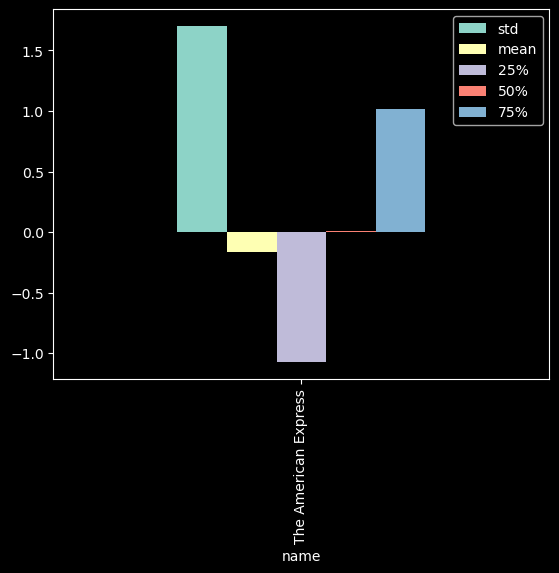

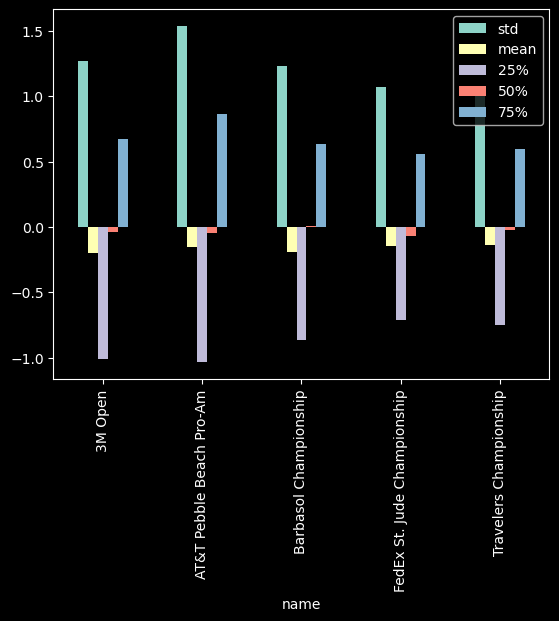

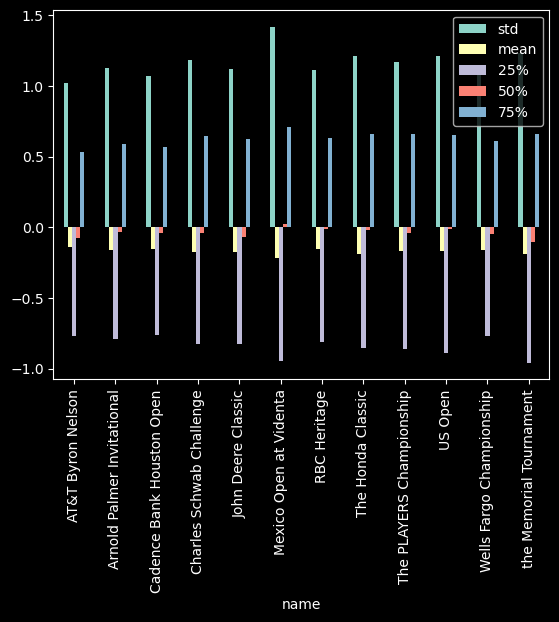

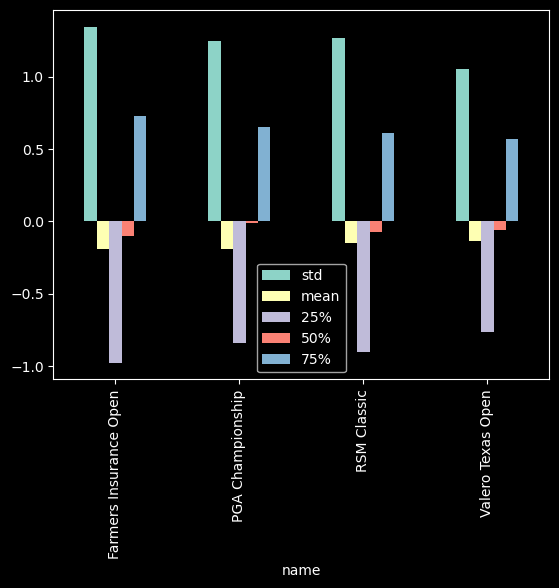

In [174]:
plots(approach_clustered)

### Tee to Green by Tournament

In [175]:
# side note: I have chosen 5 clusters for this it seemed to give the best results
# and it makes sense to group the tournaments into 5 groups so the groups are fairly small
# and even

# cluster the stats for tee 2 green strokes gained
kmeans4 = KMeans(5, tee_2_green.copy(), ['mean', 'min', '25%', '50%', '75%', 'max'])

# create the clusters
clusters = kmeans4.fit(True)
tee_2_green_clustered = kmeans4.transform()

# display the data
print(tee_2_green_clustered.head(), tee_2_green_clustered['cluster'].value_counts(), sep='\n')

                            count      mean       std    min      25%    50%  \
name                                                                           
3M Open                     617.0 -0.343464  1.813532 -8.263 -1.30000 -0.120   
AT&T Byron Nelson           778.0 -0.288640  1.592811 -9.134 -1.13125 -0.074   
AT&T Pebble Beach Pro-Am    928.0 -0.267408  2.108372 -9.218 -1.53725 -0.062   
Arnold Palmer Invitational  725.0 -0.330248  1.745903 -9.529 -1.34900 -0.141   
BMW Championship            412.0 -0.002097  1.104089 -3.033 -0.73075 -0.011   

                               75%    max  cluster  
name                                                
3M Open                     0.9650  4.160        4  
AT&T Byron Nelson           0.7975  3.577        3  
AT&T Pebble Beach Pro-Am    1.1755  5.569        4  
Arnold Palmer Invitational  0.8940  3.369        3  
BMW Championship            0.7140  3.397        2  
1    11
4    10
3     9
2     3
0     1
Name: cluster, dtype: int64


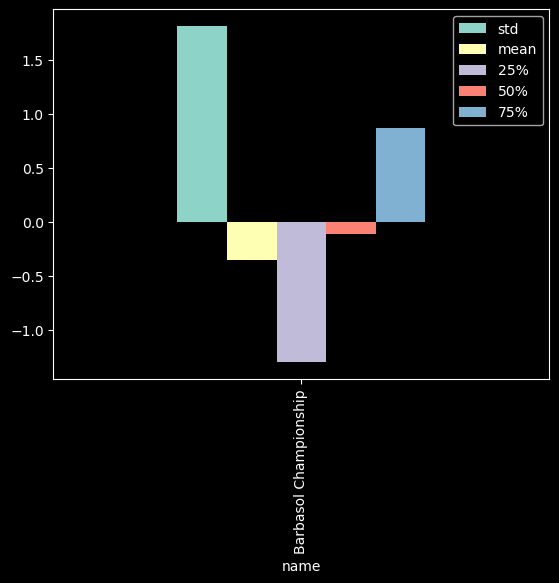

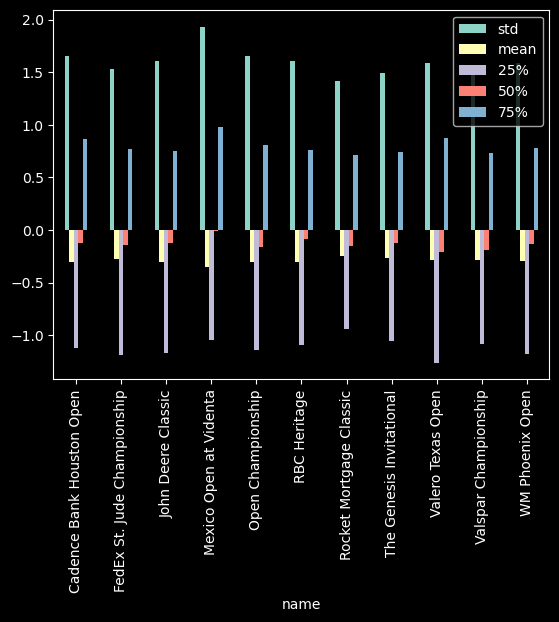

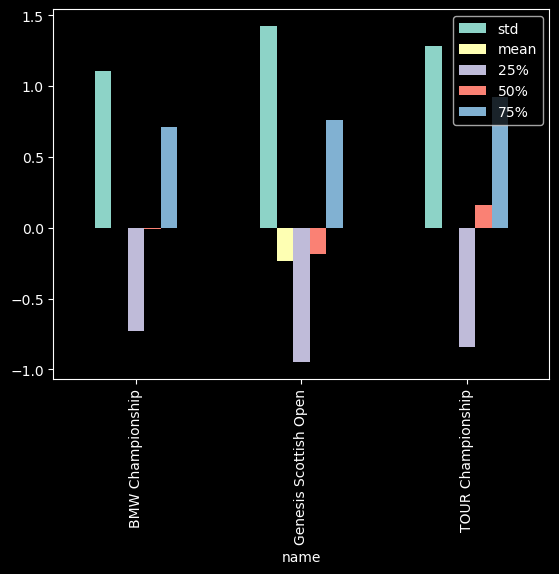

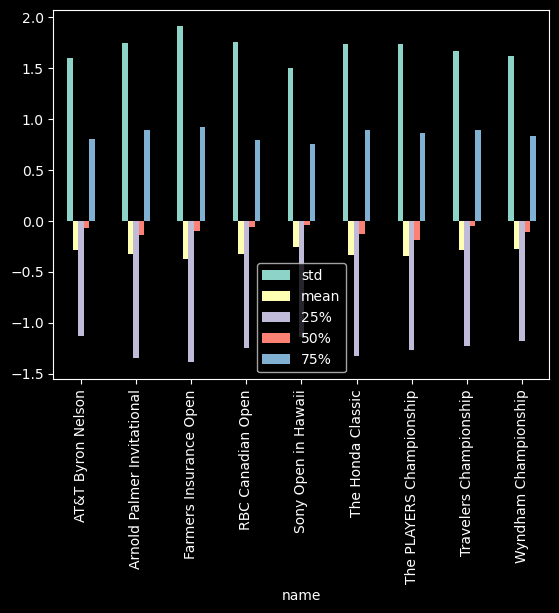

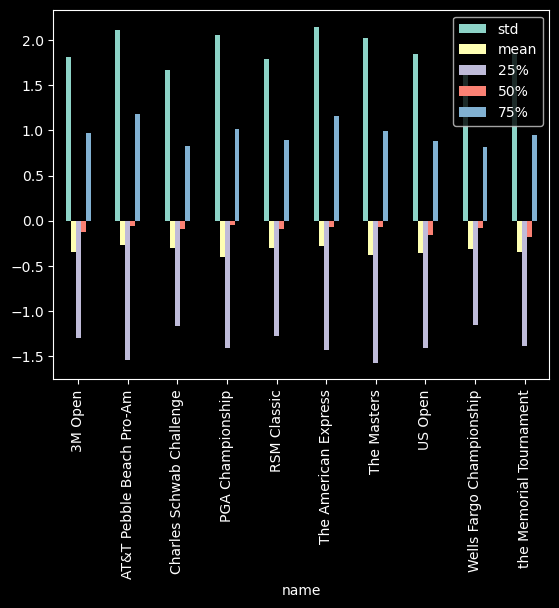

In [176]:
plots(tee_2_green_clustered)

### Off The Tee by Tournament

In [177]:
# side note: I have chosen 5 clusters for this it seemed to give the best results
# and it makes sense to group the tournaments into 5 groups so the groups are fairly small
# and even

# cluster stats for off the tee stats
kmeans5 = KMeans(5, off_the_tee.copy(), ['mean', 'min', '25%', '50%', '75%', 'max'])

# create clusters
clusters = kmeans5.fit(True)
off_the_tee_clustered = kmeans5.transform()

# display updated data
print(off_the_tee_clustered.head(), off_the_tee_clustered['cluster'].value_counts(), sep='\n')

                            count      mean       std    min      25%    50%  \
name                                                                           
3M Open                     617.0 -0.098366  0.932635 -5.571 -0.57400  0.080   
AT&T Byron Nelson           778.0 -0.079194  0.816656 -4.312 -0.50225 -0.010   
AT&T Pebble Beach Pro-Am    928.0 -0.058317  0.938516 -5.091 -0.48500  0.088   
Arnold Palmer Invitational  725.0 -0.087425  0.829298 -5.029 -0.52000  0.016   
BMW Championship            412.0 -0.000709  0.554124 -1.500 -0.38500 -0.004   

                                75%    max  cluster  
name                                                 
3M Open                     0.53100  1.890        2  
AT&T Byron Nelson           0.46450  1.780        1  
AT&T Pebble Beach Pro-Am    0.57500  1.950        2  
Arnold Palmer Invitational  0.48200  1.811        2  
BMW Championship            0.36925  2.008        0  
1    14
2     9
3     7
0     3
4     1
Name: cluster, dtype:

### Merge Data

In [178]:
# merge to get all clusters together
df.columns

Index(['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'tournament_id',
       'name', 'year', 'location'],
      dtype='object')

In [179]:
# perform merge
dfs = [putting_clustered, around_green_clustered, approach_clustered, tee_2_green_clustered, off_the_tee_clustered]
cluster_cols = ['putting', 'around_green', 'approach', 'tee_2_green', 'off_the_tee']
idx = 0

# renaming cluster columns to help data make ore sense
for frame in dfs:
    frame.rename({'cluster': cluster_cols[idx]}, axis=1, inplace=True)
    idx += 1

# merging ...
all_clusters = (df.loc[:, ['tournament_id', 'name']]
    .merge(putting_clustered.iloc[:, -1], on='name')
    .merge(around_green_clustered.iloc[:, -1], on='name')
    .merge(approach_clustered.iloc[:, -1], on='name')
    .merge(tee_2_green_clustered.iloc[:, -1], on='name')
    .merge(off_the_tee_clustered.iloc[:, -1], on='name')
    .drop_duplicates()
)

print(all_clusters.head())

     tournament_id                     name  putting  around_green  approach  \
0               22  the Memorial Tournament        1             4         3   
118            124  the Memorial Tournament        1             4         3   
237            125  the Memorial Tournament        1             4         3   
367            126  the Memorial Tournament        1             4         3   
487            127  the Memorial Tournament        1             4         3   

     tee_2_green  off_the_tee  
0              4            1  
118            4            1  
237            4            1  
367            4            1  
487            4            1  


### Lets See how our cluster work to identify a tournament

In [180]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

rf = RandomForestClassifier()
x = all_clusters.iloc[:, 2:]
y = all_clusters['name']

xtr, xte, ytr, yte = train_test_split(x, y, test_size=.33, random_state=42)

rf.fit(xtr, ytr)
rf.score(xte, yte)

0.9827586206896551

In [181]:
len(yte) * 0.9827586206896551, len(yte)

(57.0, 58)

In [182]:
all_clusters.to_csv('all_cluster.csv', index=False)